In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

from google.colab import drive
drive.mount('/content/drive')

video_path = '/content/drive/My Drive/dolphinsrgan.mp4'
frames_dir = '/content/drive/My Drive/frames'
os.makedirs(frames_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
cap = cv2.VideoCapture(video_path)
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_path = os.path.join(frames_dir, f"frame_{frame_count:04d}.png")
    cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    frame_count += 1
cap.release()

print(f"Extracted {frame_count} frames to {frames_dir}")

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hr_img = cv2.resize(img, (256, 256)) / 127.5 - 1.0
    lr_img = cv2.resize(img, (64, 64)) / 127.5 - 1.0
    return lr_img, hr_img

lr_images, hr_images = [], []
for frame_file in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_file)
    lr, hr = preprocess_image(frame_path)
    lr_images.append(lr)
    hr_images.append(hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print(f"Prepared {lr_images.shape[0]} low-resolution and high-resolution image pairs")



KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


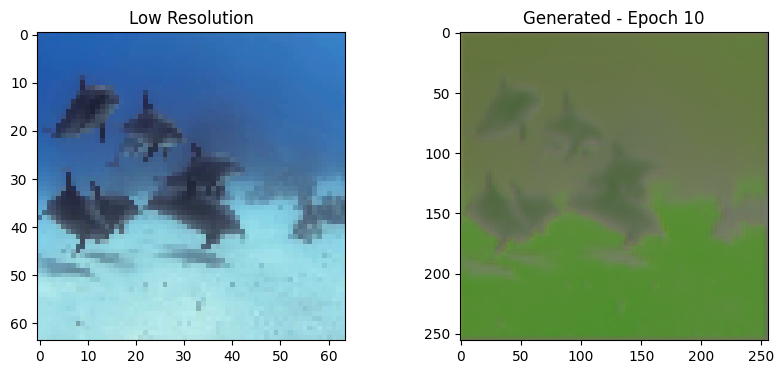

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


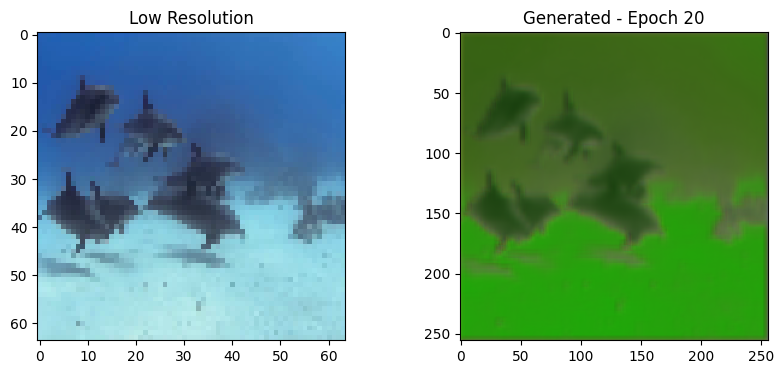

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


KeyboardInterrupt: 

In [ ]:

def build_generator():
    inputs = Input(shape=(64, 64, 3))
    x = UpSampling2D(size=2)(inputs)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)
    return Model(inputs, x, name='generator')

def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs, x, name='discriminator')

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
lr_inputs = Input(shape=(64, 64, 3))
gen_hr = generator(lr_inputs)
validity = discriminator(gen_hr)
combined = Model(lr_inputs, validity)
combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

epochs = 2000
batch_size = 16

for epoch in range(epochs):
    idx = np.random.randint(0, lr_images.shape[0], batch_size)
    lr_batch = lr_images[idx]
    hr_batch = hr_images[idx]
    gen_hr = generator.predict(lr_batch)

    d_loss_real = discriminator.train_on_batch(hr_batch, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_hr, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch(lr_batch, np.ones((batch_size, 1)))

    if (epoch + 1) % 10 == 0:
        #print(f"[Epoch {epoch + 1}/{epochs}] [D loss: {d_loss[0]:.4f}, acc: {100 * d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

        sample_lr = lr_images[:1]
        sample_hr = generator.predict(sample_lr)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow((sample_lr[0] + 1) / 2)
        plt.title("Low Resolution")
        plt.subplot(1, 2, 2)
        plt.imshow((sample_hr[0] + 1) / 2)
        plt.title(f"Generated - Epoch {epoch + 1}")
        plt.show()


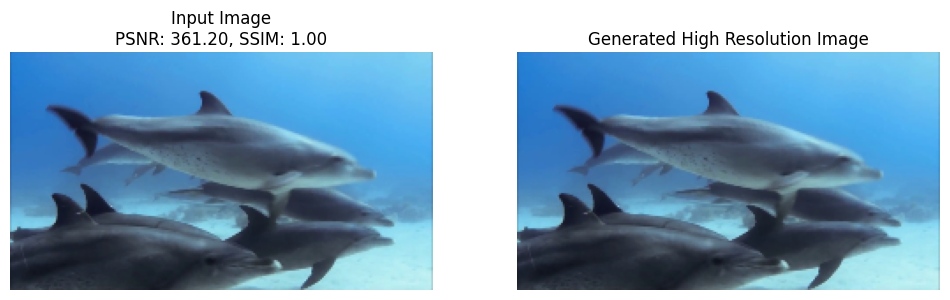

High resolution video copied to: /content/drive/My Drive/high_res_dolphinsrgan.mp4


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 134 and the array at index 1 has size 540

In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def downsample_image(image):
    return cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))

from skimage.metrics import structural_similarity as ssim

def compute_metrics(original, reconstructed, window_size=3):
    original = cv2.convertScaleAbs(original)
    reconstructed = cv2.convertScaleAbs(reconstructed)

    psnr_value = cv2.PSNR(original, reconstructed)

    ssim_value = ssim(original, reconstructed, multichannel=True, win_size=window_size)

    return psnr_value, ssim_value

frames_dir = '/content/drive/My Drive/frames'
lr_images, hr_images = [], []

for frame_file in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_file)
    img = cv2.imread(frame_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    lr_img = downsample_image(img_rgb)

    hr_img = cv2.resize(img_rgb, (lr_img.shape[1], lr_img.shape[0]))

    lr_images.append(lr_img)
    hr_images.append(hr_img)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

random_index = np.random.randint(0, len(lr_images))
lr_sample = lr_images[random_index]
hr_sample = hr_images[random_index]

psnr_value, ssim_value = compute_metrics(hr_sample, lr_sample)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(lr_sample)
axes[0].set_title(f"Input Image\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")
axes[0].axis('off')
axes[1].imshow(hr_sample)
axes[1].set_title("Generated High Resolution Image")
axes[1].axis('off')
plt.show()

def create_video_from_images(image_list, output_path, frame_rate=30):
    height, width, layers = image_list[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    for img in image_list:
        video_writer.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    video_writer.release()

import shutil

low_res_video_path = '/content/drive/My Drive/low_res_dolphinsrgan.mp4'
create_video_from_images(lr_images, low_res_video_path)

high_res_video_path = '/content/drive/My Drive/high_res_dolphinsrgan.mp4'

shutil.copy(video_path, high_res_video_path)

print(f"High resolution video saved to: {high_res_video_path}")

from google.colab.patches import cv2_imshow

cap_lr = cv2.VideoCapture(low_res_video_path)
cap_hr = cv2.VideoCapture(high_res_video_path)

while cap_lr.isOpened() and cap_hr.isOpened():
    ret_lr, frame_lr = cap_lr.read()
    ret_hr, frame_hr = cap_hr.read()

    if not ret_lr or not ret_hr:
        break
    combined_frame = np.hstack((frame_lr, frame_hr))
    cv2_imshow(combined_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_lr.release()
cap_hr.release()
cv2.destroyAllWindows()
